# This project analyze the online retail sales data to understand the possible group of customers based on recency, frequency, and monetary values using K-means clustering.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import datetime as dt

import warnings
warnings.filterwarnings("ignore")

In [4]:
# read data
xls = pd.ExcelFile('Online Retail.xlsx')
data = pd.read_excel(xls, 'Online Retail')

In [5]:
print(data.head())
print(data.tail())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
       InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S A

In [6]:
data.shape

(541909, 8)

# Exploratory Data Analysis

In [9]:
def summary(data, pred=None):
    obs = data.shape[0]
    types = data.dtypes
    counts = data.apply(lambda x: x.count())
    min = data.min()
    uniques = data.apply(lambda x: x.unique().shape[0])
    nulls = data.apply(lambda x: x.isnull().sum())
    print('Data shape:', data.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'uniques', 'nulls', 'min']
        str = pd.concat([types, counts, uniques, nulls, min], axis = 1, sort = True)
    
    str.columns = cols
    #dtypes = str.types.value_counts()
    print('__________________\nData types:')
    print(str.types.value_counts())
    print('_________________')
    return str

details = summary(data)
display(details.sort_values(by='nulls', ascending=False))

Data shape: (541909, 8)
__________________
Data types:
object            4
float64           2
int64             1
datetime64[ns]    1
Name: types, dtype: int64
_________________


,types,counts,uniques,nulls,min
CustomerID,float64,406829,4373,135080,12346.0
Description,object,540455,4224,1454,NaN
Country,object,541909,38,0,Australia
InvoiceDate,datetime64[ns],541909,23260,0,2010-12-01 08:26:00
InvoiceNo,object,541909,25900,0,NaN
Quantity,int64,541909,722,0,-80995
StockCode,object,541909,4070,0,NaN
UnitPrice,float64,541909,1630,0,-11062.06


In [10]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [12]:
data.loc[(data.UnitPrice<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [13]:
data.loc[(data.Quantity<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [14]:
## there are 10624 rows with negative quantity which should be cancelled orders
## even the negative unit price should be cancelled orders or mistake.

In [15]:
# lets check the null values
data.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [16]:
# 25% rows don't have CustomerID, can we drop them? Description we can fill?

In [17]:
# find customer counts based on countries
data.Country.value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [18]:
# United Kingdom contribute 91% rows, lets only keep data for United Kingdom for easyness to analyze customer behaviors

data = data[data.Country == 'United Kingdom']

In [19]:
# lets remove the rows with negative value of Unit Price and Quantity

data = data[data.Quantity > 0]
data = data[data.UnitPrice > 0]

# Remove the rows with CustomerID as null
data = data[pd.notnull(data['CustomerID'])]

In [25]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceYearMonth'] = data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
data['Date'] = data['InvoiceDate'].dt.strftime('%Y-%m')

In [20]:
data.isnull().mean()*100

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [22]:
# Most important variables for our analysis are CustomerID, UnitPrice, Quantity, & InvoiceDate
data.shape

(354321, 8)

In [26]:
# Aggregate the orders by Month
data_agg_month = data.groupby("Date").Quantity.sum()
data_agg_month

Date
2010-12    267767
2011-01    278251
2011-02    213375
2011-03    276304
2011-04    260448
2011-05    301824
2011-06    280974
2011-07    303601
2011-08    310831
2011-09    454559
2011-10    476984
2011-11    571215
2011-12    260607
Name: Quantity, dtype: int64

In [28]:
# convert above data into a dataframe so we can plot graph
data_agg_month = pd.DataFrame(data_agg_month)
data_agg_month = data_agg_month.reset_index()
data_agg_month.head()

,Date,Quantity
0,2010-12,267767
1,2011-01,278251
2,2011-02,213375
3,2011-03,276304
4,2011-04,260448


In [33]:
def plot_data(data, x, y, title="", xlabel = 'Date', ylabel = 'Orders', dpi = 100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.plot(x,y, color='tab:Blue', marker='o')
    plt.show()

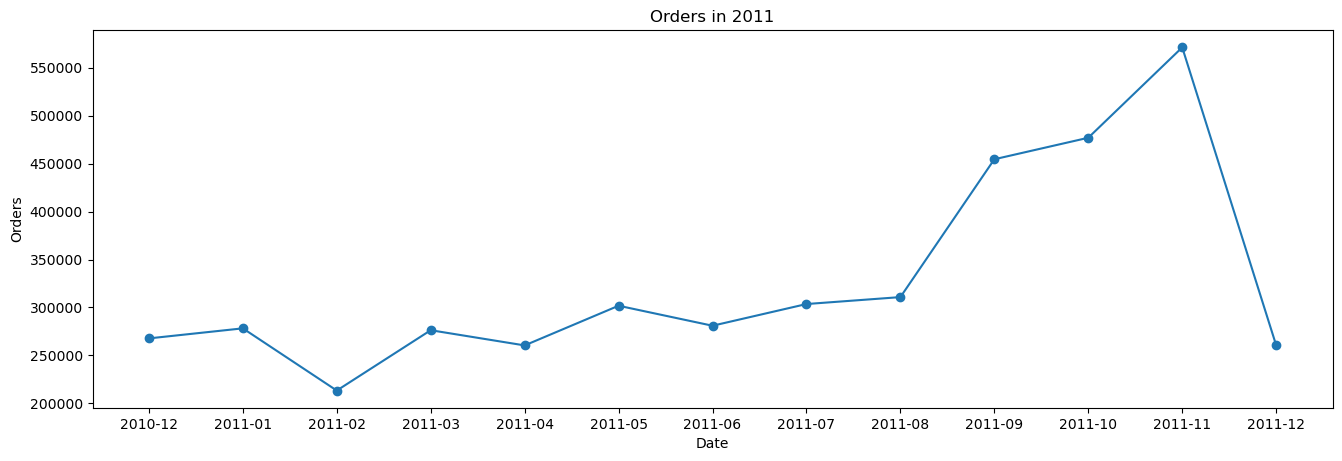

In [34]:
plot_data(data_agg_month, x=data_agg_month.Date, y=data_agg_month.Quantity, title='Orders in 2011')

# Revenue

<AxesSubplot:xlabel='Quantity'>

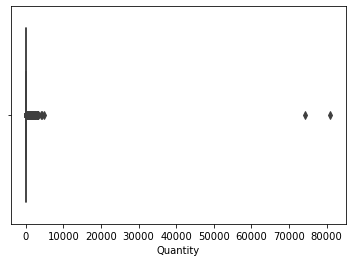

In [36]:
data['Revenue'] = data['Quantity']*data['UnitPrice']
sns.boxplot(x=data['Quantity'])

In [37]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Date,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12,20.34


# Monthly Revenue

In [43]:
data_revenue = data.groupby(['Date'])['Revenue'].sum().reset_index()
data_revenue.head()

,Date,Revenue
0,2010-12,498661.850
1,2011-01,442190.060
2,2011-02,355655.630
3,2011-03,467198.590
4,2011-04,409559.141


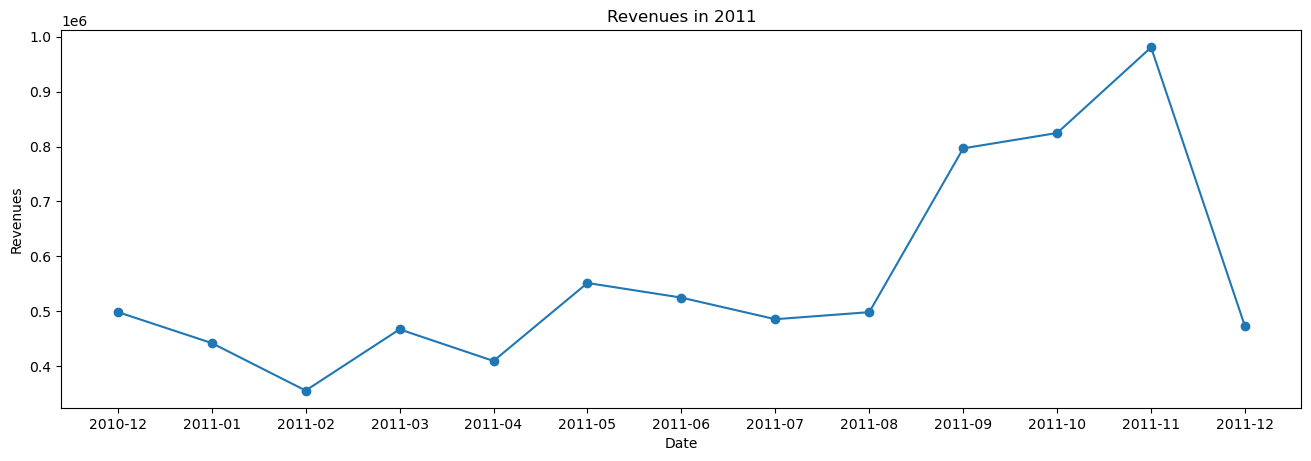

In [46]:
plot_data(data_revenue, x=data_revenue.Date, y=data_revenue.Revenue, xlabel = 'Date', ylabel = 'Revenues', title='Revenues in 2011')

# RFM (Recency - Frequency - Monetary) Analysis

In [48]:
# The RFM Analysis clusters/segments customers based on their recent purchase behavior, frequency of purchasea and 
# the total money spent by each customers.

# Last date in our data is 2011-12-09, and this will be used to calculate the recency
NOW = dt.date(2011,12,9)
data['Date'] = pd.DatetimeIndex(data.InvoiceDate).date

# Recency

In [49]:
data_recency = data.groupby(['CustomerID'], as_index=False)['Date'].max()
data_recency.columns = ['CustomerID', 'Last_Purchase_Date']

data_recency['Recency'] = data_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
data_recency.drop(columns=['Last_Purchase_Date'], inplace=True)
data_recency.head()

,CustomerID,Recency
0,12346.0,325
1,12747.0,2
2,12748.0,0
3,12749.0,3
4,12820.0,3


# Frequency-Monetary

In [50]:
FM_Table = data.groupby('CustomerID').agg({'InvoiceNo': lambda x:len(x),
                                          'Revenue': lambda x:x.sum()})

FM_Table.rename(columns = {'InvoiceNo': 'Frequency',
                          'Revenue': 'Monetary'}, inplace=True)

FM_Table.head()

,Frequency,Monetary
CustomerID,,
12346.0,1,77183.60
12747.0,103,4196.01
12748.0,4595,33719.73
12749.0,199,4090.88
12820.0,59,942.34


In [52]:
RFM_Table = data_recency.merge(FM_Table, left_on = 'CustomerID', right_on = 'CustomerID')
RFM_Table.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4595,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


In [53]:
(NOW - dt.date(2011,1,18)).days == 325

True

In [54]:
# Now we have a table of Recency, Frequency, and Monetary value for each Customers. we can give value from 1 to 4 for 
# each Recency, Frequency, and Monetary. 1 for highest value and 4 to the lowest. we can later calculate the RFM Score
# by combining individual RFM score numbers.

In [55]:
quantiles = RFM_Table.quantile(q=[0.25, 0.50, 0.75])
quantiles = quantiles.to_dict()

In [56]:
segmented_rfm = RFM_Table.copy()

In [57]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [59]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency', quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency', quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary', quantiles))
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile
0,12346.0,325,1,77183.60,4,4,1
1,12747.0,2,103,4196.01,1,1,1
2,12748.0,0,4595,33719.73,1,1,1
3,12749.0,3,199,4090.88,1,1,1
4,12820.0,3,59,942.34,1,2,2


# lets get the total RFM score

### RFM_Score = R_quartile + F_quartile + M_quartile

In [60]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str) + segmented_rfm.F_quartile.map(str) + segmented_rfm.M_quartile.map(str)

In [61]:
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment
0,12346.0,325,1,77183.60,4,4,1,441
1,12747.0,2,103,4196.01,1,1,1,111
2,12748.0,0,4595,33719.73,1,1,1,111
3,12749.0,3,199,4090.88,1,1,1,111
4,12820.0,3,59,942.34,1,2,2,122


In [62]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

In [63]:
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,12346.0,325,1,77183.60,4,4,1,441,9
1,12747.0,2,103,4196.01,1,1,1,111,3
2,12748.0,0,4595,33719.73,1,1,1,111,3
3,12749.0,3,199,4090.88,1,1,1,111,3
4,12820.0,3,59,942.34,1,2,2,122,5


In [64]:
segmented_rfm['RFM_Score'].unique()

array([ 9,  3,  5, 12,  7,  8,  6, 10, 11,  4], dtype=int64)

In [65]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3             6.6     363.7   8218.2   409
4            20.3     187.0   3492.1   345
5            32.0     113.3   1909.4   386
6            47.0      78.9   1806.6   380
7            60.5      55.4    917.1   408
8            78.1      38.5    733.0   393
9            96.7      28.4    829.5   424
10          153.0      21.0    357.0   470
11          174.0      13.7    234.2   362
12          257.9       8.1    152.3   343

# K-Means Clustering for RFM Customer Segmentation

#### K-means gives best result under the following conditions:
    . Data's distribution is not skewed (i.e. long-tail distribution)
    . Data is standardised (i.e. mean of 0 and standard deviation of 1)

####  Lets plot chart to understand data skewness

In [67]:
## Function to check skewness:

def check_skew(data_skew, column):
    skew = stats.skew(data_skew[column])
    skewtest = stats.skewtest(data_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(data_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 1.244516494686479, : SkewtestResult(statistic=25.283720058978158, pvalue=4.8246481722257944e-141)
Frequency's: Skew: 18.66163311873067, : SkewtestResult(statistic=80.10349526126947, pvalue=0.0)
Monetary's: Skew: 20.190728787200957, : SkewtestResult(statistic=81.75346911703686, pvalue=0.0)


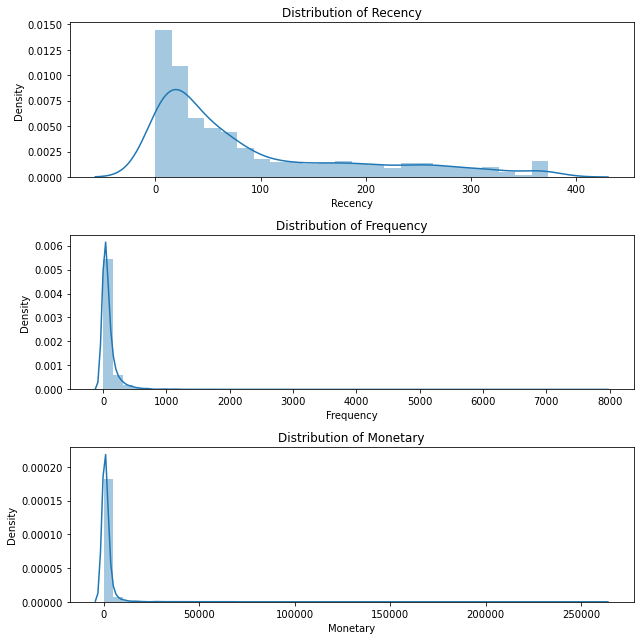

In [68]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_Table,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table,'Monetary')

plt.tight_layout()

In [71]:
# the data are highly skewed. log scale are used to remove/fix the skewness

data_rfm_log = RFM_Table.copy()
data_rfm_log.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4595,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


Recency's: Skew: -0.4635591539552193, : SkewtestResult(statistic=-11.314301280234206, pvalue=1.114869536941138e-29)
Frequency's: Skew: -0.02600696239989871, : SkewtestResult(statistic=-0.6659021000684195, pvalue=0.5054736781086501)
Monetary's: Skew: 0.3694308288045071, : SkewtestResult(statistic=9.166088768517884, pvalue=4.904929990328552e-20)


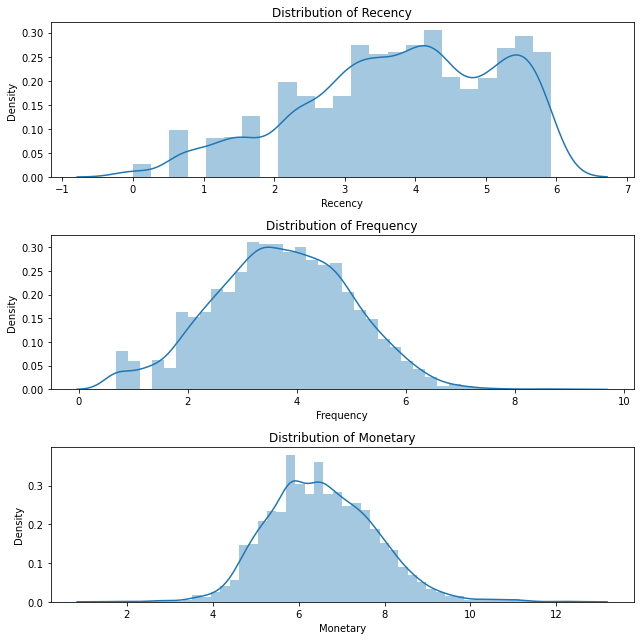

In [72]:
data_rfm_log = np.log(data_rfm_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(data_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(data_rfm_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(data_rfm_log,'Monetary')

plt.tight_layout()

In [75]:
# now lets standardise the data by centring and scaling, all variables will have a mean of 0 and st. deviation of 1.

scaler = StandardScaler()
scaler.fit(data_rfm_log)
RFM_Table_scaled = scaler.transform(data_rfm_log)

In [76]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=data_rfm_log.columns)
RFM_Table_scaled.head()

,CustomerID,Recency,Frequency,Monetary
0,-2.216570,1.438428,-2.403387,3.785914
1,-1.903521,-1.953555,0.732578,1.444280
2,-1.902753,-2.748403,3.739419,3.119983
3,-1.901985,-1.745416,1.251577,1.423880
4,-1.847594,-1.745416,0.296025,0.243880


# K-Means Clustering

#### Find the optimal number of clusters

In [77]:
from scipy.spatial.distance import cdist

In [78]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_

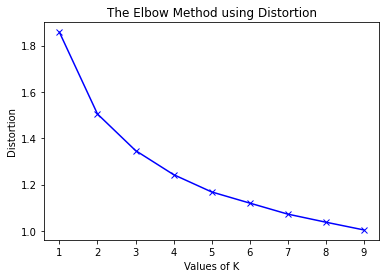

In [79]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

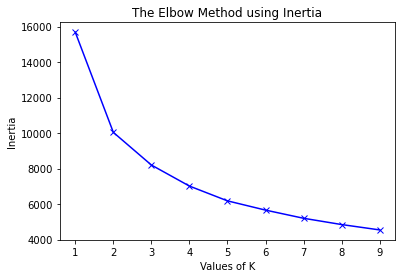

In [80]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [88]:
# from both elbow method using distortion and intertia, first drop is in cluster 2 and then gradual decrease. lets use other 
# plots to better understand the optimal number of clusters. from above plots clusters around 4-5 can be optimum numbers.

In [82]:
def kmeans(normalised_data_rfm, clusters_number, original_data_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_data_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    data_new = original_data_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(data_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return data_new

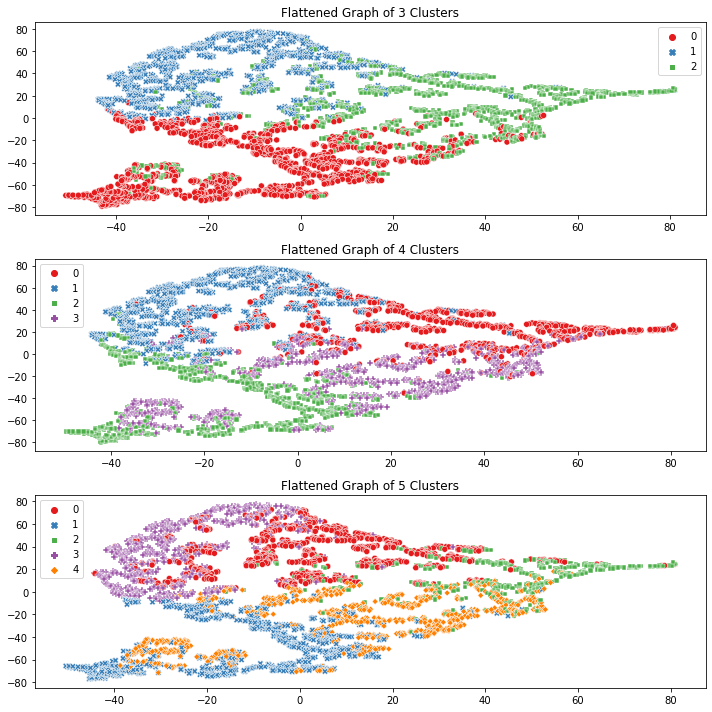

In [86]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
data_rfm_k3 = kmeans(RFM_Table_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
data_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
data_rfm_k5 = kmeans(RFM_Table_scaled, 5, RFM_Table)

plt.tight_layout()

In [84]:
def snake_plot(normalised_data_rfm, data_rfm_kmeans, data_rfm_original):

    normalised_data_rfm = pd.DataFrame(normalised_data_rfm, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised_data_rfm['Cluster'] = data_rfm_kmeans['Cluster']

    # Melt data into long format
    data_melt = pd.melt(normalised_data_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=data_melt, x='Metric', y='Value', hue='Cluster')
    
    return

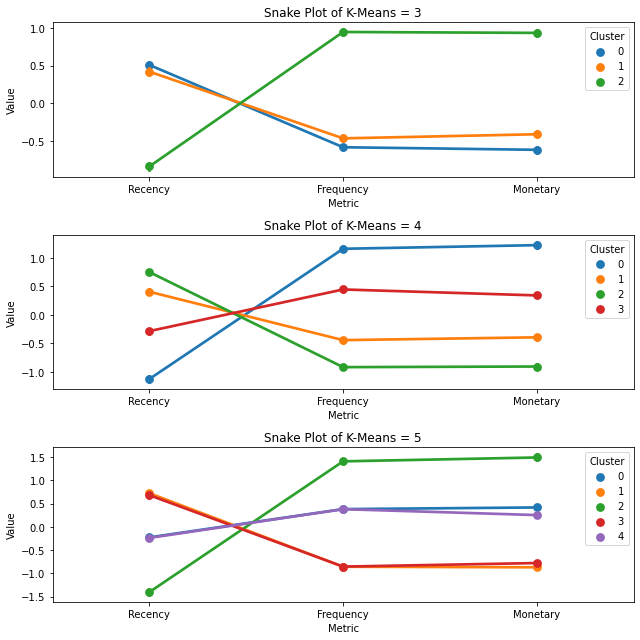

In [89]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_Table_scaled, data_rfm_k3, RFM_Table)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, data_rfm_k4, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_scaled, data_rfm_k5, RFM_Table)

plt.tight_layout()

##### From the flattened graph and Snake plot, 4 clusters / segments are the perfect representation of the data.

# Clusters interpreations:

In [90]:
def rfm_values(data):

    data_new = data.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return data_new

In [91]:
rfm_values(data_rfm_k4)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          16.0     264.0   6138.0   763
1         118.0      32.0    691.0  1108
2         171.0      17.0    296.0   959
3          48.0      93.0   1446.0  1090

#### Cluster 0 represents best customers in terms of recent, frequent, and higher monetary value.
#### Cluster 1 represents customers who purchased long time ago, with the 3rd lowest frequency, and 3rd lowest monetary value.
#### Cluster 2 represents group of customers whose last purchased date is the longest time ago, with the lowest frequency, and the lowest monetary value. These customers are of low value customers or purchase/spend the least amounts of money.
#### Cluster 3 is the second best customer group in terms of the three values. This group got second highest number of customers.